# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

In [80]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [81]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.1'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical represetnation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [82]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create 
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze to make this a 50x1 matrix
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [83]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [84]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [85]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """_summary_
    Plots training data, test data and compares predictions.
    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Are there predictions?
    if predictions != None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Show the legend
    plt.legend(prop={"size": 14})

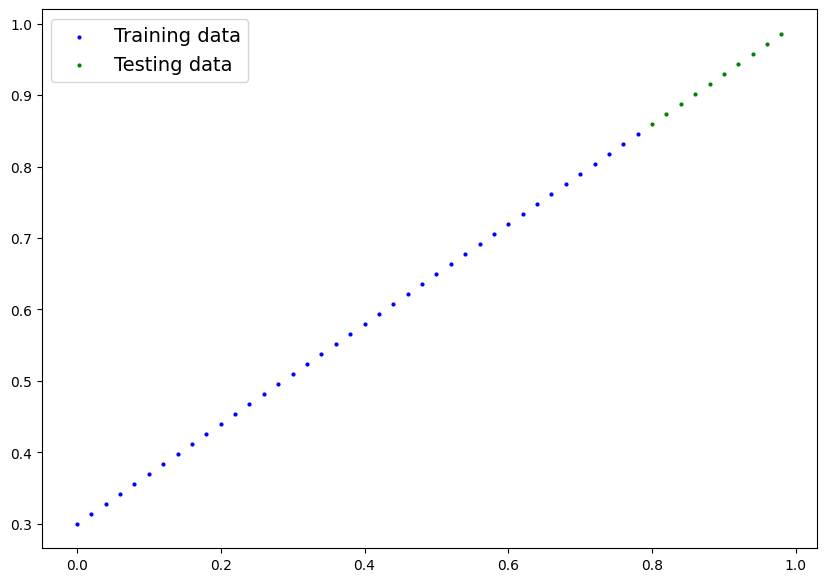

In [86]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the ranodm values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [87]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* ```torch.nn``` - contains all of the building blocks for computation graphs (a neural network can be considered a computational graph)
* ```torch.nn.Parameter``` - what parameters should our model try and learn, often a PyTorch layer from ```torch.nn``` will set these for us
* ```torch.nn.Module``` - the base class for all neural network modules, if you sublcass it, you should overwrite ```forward()```
* ```torch.optim``` - this is where the optimizers in PyTorch live, they will help with gradient descent
* ```def forward()``` - All nn.Module subclasses require you to overwrite ```forward()```, this method defines what happens in the forward computation
* ```torch.utils.data.Dataset``` - Represents a map between key (label) and sample (features) pairs of your data. Such as images and their associated labels.
* ```torch.utils.data.DataLoader``` - Creates a Python iterable over a torch Dataset (allows you to iterate over your data).

In [88]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters - or what's inside our model - using ```.parameters()```.

In [89]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [90]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [91]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [92]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [93]:
# Make predictions with model
with torch.inference_mode():
    # NOW we have no gradient attached
    # Disables the useful things available during training, so PyTorch is keeping track of less data
    # With a larger data set, this will make predictions WAY faster
    y_preds = model_0(X_test)
    
# Notice no gradient is attached to this output tensor
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [94]:
with torch.no_grad():
    # You can do something similar with torch.no_grad(), HOWEVER, torch.inference_mode() is preferred
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [95]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

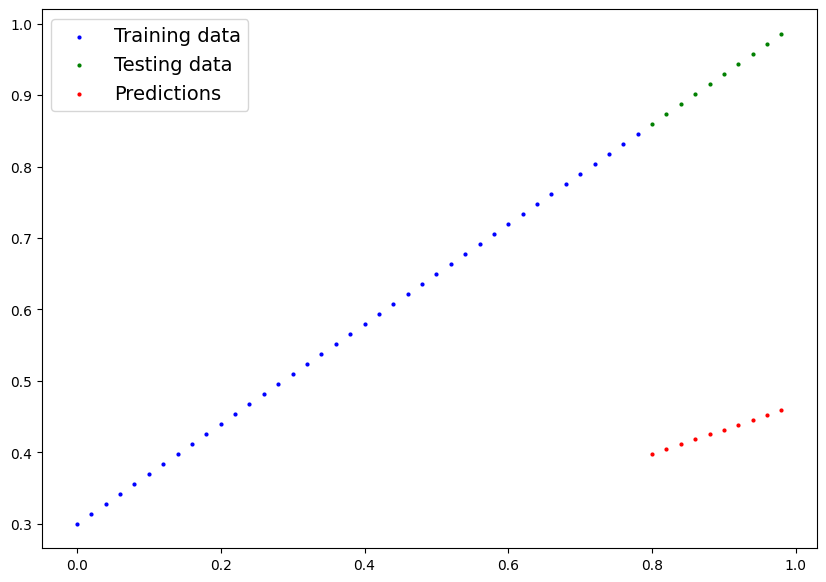

In [96]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your model's predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [97]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [98]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [99]:
# Set up a loss function
loss_fn = nn.L1Loss()

# Set up an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:<br>
Loop through the data and do...
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [100]:
torch.manual_seed(42)

# An epoch is one loop through the data...
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch set
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop, so... we have to zero them above in step 4 for the next iteration of the loop
    
    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batchnorm layers)
    with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    # Print out what's happenin'
    if epoch % (epochs / 10) == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        print(f"Model: {model_0.state_dict()}")

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
Model: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
Model: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 40 | Test: 0.04543796554207802 | Test loss: 0.11360953003168106
Model: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 60 | Test: 0.03818932920694351 | Test loss: 0.08886633068323135
Model: OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch: 80 | Test: 0.03132382780313492 | Test loss: 0.07232122868299484
Model: OrderedDict([('weights', tensor([0.5459])), ('bias', tensor([0.3648]))])
Epoch: 100 | Test: 0.024458957836031914 | Test loss: 0.05646304413676262
Model: OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])
Epoch: 120 | Test: 0.01758546754717827 | Test loss: 0.04060482233762741
Model: OrderedDict([(

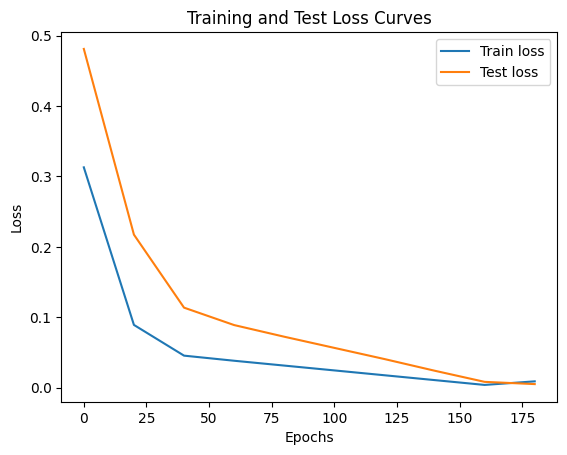

In [101]:
# Plot the loss curves
plt.plot(epoch_count, [loss.detach().numpy() for loss in loss_values], label="Train loss")
plt.plot(epoch_count, [test_loss.numpy() for test_loss in test_loss_values], label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [102]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [103]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [104]:
weight, bias

(0.7, 0.3)

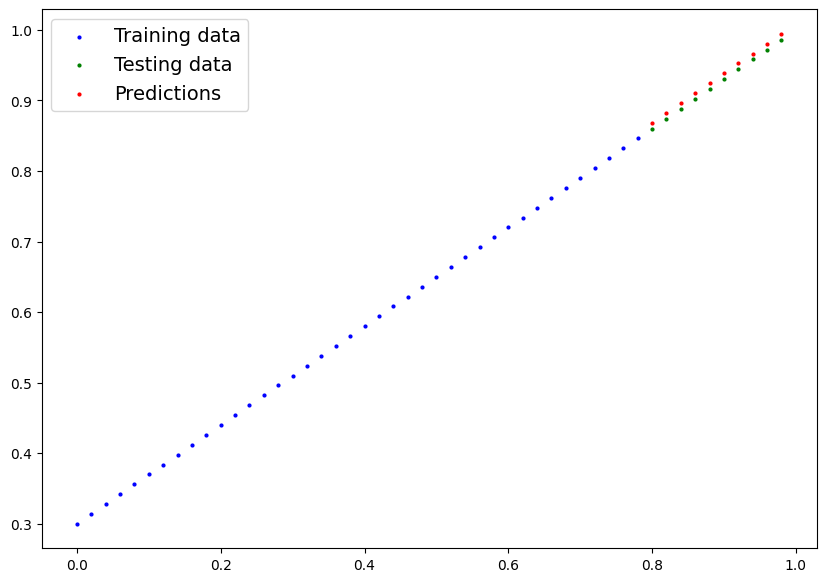

In [105]:
plot_predictions(predictions=y_preds_new)